In [1]:
!pip install statsmodels

In [2]:
import os
import sys
import copy
import pickle
import re
import requests
from io import BytesIO

import numpy as np
import scipy
import scipy.io as sio
import scipy.stats
import scipy.fft
from scipy.io import loadmat
from scipy.fft import fft
from scipy.fftpack import fft as fftpack_fft
from scipy.signal import (
    hilbert, welch, spectrogram, correlate, savgol_filter, resample
)
from scipy.interpolate import interp1d, griddata
from scipy.spatial import cKDTree
from scipy.spatial.distance import euclidean
from scipy.stats import entropy, pearsonr, zscore

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import plotly.express as px

import pandas as pd

from sklearn.preprocessing import normalize, Normalizer, StandardScaler
from sklearn.decomposition import PCA, FastICA
import umap.umap_ as umap
import skdim

import yasa
import pynapple as nap
import emd
import emd.sift as sift
import emd.spectra as spectra
from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import (
    filter_signal,
    filter_signal_fir,
    design_fir_filter
)
from neurodsp.aperiodic import compute_fluctuations

from spectral_connectivity import (
    Multitaper,
    Connectivity,
    multitaper_connectivity
)
from specparam import SpectralModel
import EntropyHub as EH
from scipy.spatial import cKDTree

from tqdm import tqdm
from utils import *
from detect_pt import *

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
#Functions:
def get_data2(lfp_path, state_path):

    data = scipy.io.loadmat(lfp_path)
    states = scipy.io.loadmat(state_path)

    lfp = np.squeeze(data['PFC'])
    hypno = np.squeeze(states['states'])

    fs = extract_frequency_sampling(lfp, hypno)

    unique = np.unique(hypno)
    if unique[0] == 0:
        print('There was 0 in the dataset')
        lfp = lfp[7*fs:-11*fs]
        hypno = hypno[7:-11]
    else:
        None

    return lfp, hypno, fs

def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 2500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    # Apply a 900 ms duration threshold to phasic intervals
    phasic_interval = nap.IntervalSet(start, end)
    min_duration1 = 0.9  # 900 ms in seconds
    durations1 = phasic_interval['end'] - phasic_interval['start']
    valid_intervals1 = durations1 >= min_duration1
    phasic_interval = nap.IntervalSet(phasic_interval['start'][valid_intervals1], phasic_interval['end'][valid_intervals1])

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intervals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intervals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

def convert_intervals(interval_set: nap.IntervalSet):
    df = interval_set.as_dataframe()
    return df[['start', 'end']].to_numpy(dtype=float)

def split_intervals(interval_set, chunk=4, merge_threshold=2):
    if isinstance(interval_set, nap.IntervalSet):
        intervals = convert_intervals(interval_set)
    else:
        intervals = np.asarray(interval_set, dtype=float)

    result = []

    for start, end in intervals:
        cur = start
        L = end - start
        n_full = int(L // chunk)

        local = []

        for _ in range(n_full):
            nxt = cur + chunk
            local.append([round(cur, 3), round(nxt, 3)])
            cur = nxt

        rem = end - cur
        if rem > 0:
            if rem < merge_threshold and local:
                local[-1][1] = round(end, 3)
            else:
                local.append([round(cur, 3), round(end, 3)])

        result.extend(local)

    return np.array(result)

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def max_interval_size(intervals, t, lfp):
    max_size = 0

    for start, end in intervals:
        low = find_nearest(t, start)
        high = find_nearest(t, end)

        idx_low = np.where(t == low)[0][0]
        idx_high = np.where(t == high)[0][0]

        size = idx_high - idx_low
        max_size = max(max_size, size)

    return max_size

In [5]:
def get_connectivity(
    intervals,
    t,
    lfpHPC,
    lfpPFC,
    highsize,
    label,
    animal_id,
    trial_id,
    sampling_frequency=2500,
    time_halfbandwidth_product=2,
):

    frequency_set = []
    coh_set = []
    icoh_set = []
    pli_set = []
    wpli_set = []
    dspli_set = []
    wdspli_set = []
    ppc_set = []

    if len(intervals) == 0:
        return {
            "label": label,
            "animal": animal_id,
            "trial": trial_id,
            "frequencies": np.array([]),
            "coh": np.array([]),
            "icoh": np.array([]),
            "pli": np.array([]),
            "wpli": np.array([]),
            "dspli": np.array([]),
            "wdspli": np.array([]),
            "ppc": np.array([]),
        }

    for i in range(len(intervals)):
        index_low = np.argmin(np.abs(t - intervals[i, 0]))
        index_high = np.argmin(np.abs(t - intervals[i, 1]))

        signal1 = lfpHPC[index_low:index_high]
        signal2 = lfpPFC[index_low:index_high]

        pad_len1 = highsize - len(signal1)
        pad_len2 = highsize - len(signal2)

        if pad_len1 < 0 or pad_len2 < 0:
            raise ValueError("Signal length exceeds highsize!")

        signal1_padded = np.pad(signal1, (0, pad_len1), mode="constant")
        signal2_padded = np.pad(signal2, (0, pad_len2), mode="constant")

        signal_tot = np.vstack((signal1_padded, signal2_padded)).T

        time = t[index_low:index_high]
        time_padded = np.pad(time, (0, highsize - len(time)), mode="constant")

        multitaper = Multitaper(
            signal_tot,
            sampling_frequency=sampling_frequency,
            time_halfbandwidth_product=time_halfbandwidth_product,
            start_time=time_padded[0],
        )

        connectivity = Connectivity.from_multitaper(multitaper)

        frequency_set.append(connectivity.frequencies)
        coh_set.append(np.abs(connectivity.coherence_magnitude()[..., 0, 1].squeeze()))
        icoh_set.append(connectivity.imaginary_coherence()[..., 0, 1].squeeze())
        pli_set.append(np.abs(connectivity.phase_lag_index()[..., 0, 1].squeeze()))
        wpli_set.append(np.abs(connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze()))
        dspli_set.append(connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze())
        wdspli_set.append(connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze())
        ppc_set.append(connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze())

    def _safe_concat(arrays):
        return np.concatenate(arrays) if len(arrays) else np.array([])

    return {
    "label": label,
    "animal": animal_id,
    "trial": trial_id,
    "frequencies": _safe_concat(frequency_set),
    "coh": _safe_concat(coh_set),
    "icoh": _safe_concat(icoh_set),
    "pli": _safe_concat(pli_set),
    "wpli": _safe_concat(wpli_set),
    "dspli": _safe_concat(dspli_set),
    "wdspli": _safe_concat(wdspli_set),
    "ppc": _safe_concat(ppc_set),
}

In [6]:
def get_phasic_connectivity(
    phasic_interval,
    t,
    lfpHPC,
    lfpPFC,
    highsize,
    animal_id,
    trial_id,
    sampling_frequency=2500,
    time_halfbandwidth_product=2,
):
    return get_connectivity(
        intervals=phasic_interval,
        t=t,
        lfpHPC=lfpHPC,
        lfpPFC=lfpPFC,
        highsize=highsize,
        label="phasic",
        animal_id=animal_id,
        trial_id=trial_id,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
    )

def get_tonic_connectivity(
    tonic_time,
    t,
    lfpHPC,
    lfpPFC,
    highsize,
    animal_id,
    trial_id,
    sampling_frequency=2500,
    time_halfbandwidth_product=2,
):
    return get_connectivity(
        intervals=tonic_time,
        t=t,
        lfpHPC=lfpHPC,
        lfpPFC=lfpPFC,
        highsize=highsize,
        label="tonic",
        animal_id=animal_id,
        trial_id=trial_id,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
    )

In [7]:
def binned_mean_sem(connectivity_dict, measure="coh", bins=[1, 5, 13, 20, 140]):
    frequency_set = connectivity_dict["frequencies"]
    connectivity_set = connectivity_dict[measure]

    mean = binned_statistic(frequency_set, connectivity_set, bins=bins, statistic="mean")
    stdev = binned_statistic(frequency_set, connectivity_set, bins=bins, statistic="std")
    n = binned_statistic(frequency_set, connectivity_set, bins=bins, statistic="count")

    bin_means = mean.statistic
    bin_stdev = stdev.statistic
    SEM = bin_stdev / np.sqrt(n.statistic)

    return bin_means, SEM

In [8]:
def concatenate_results(results_list, measure):
    return np.concatenate([r[measure] for r in results_list])

In [9]:
def concatenate_results(results, key):
    all_vals = []
    all_animals = []
    for r in results:
        all_vals.append(r[key])
        all_animals.append(r["animal"])
    return np.concatenate(all_vals), np.array(all_animals)

In [10]:
def concatenate_results(results, key):
    out = []
    for r in results:
        out.append(np.asarray(r[key]).ravel())
    return np.concatenate(out)

In [11]:
local_path = r'C:\Users\ejsev\Downloads\sleep scoring\table'
sys.path.append(local_path)  # path to dataset loader

from dataset_loader.loader import DatasetLoader

CONFIG_PATH = os.path.join(local_path, 'configos.yaml')

loader = DatasetLoader(CONFIG_PATH)
dataset_map = loader.load_datasets()


import pandas as pd

df1 = pd.DataFrame([
    {
        'Name': key,
        'StatesFile': val[0],
        'HPCFile': val[1],
        'PFCFile': val[2]
    }
    for key, val in dataset_map.items()
])

df1

03-Feb-26 15:13:53 | WARNING | Expected files not found in directory: D:\OS_Basic\Rat_1\study_day_5_OR_N\post_trial1_2017-10-03_11-05-10
03-Feb-26 15:13:53 | WARNING | Expected files not found in directory: D:\OS_Basic\Rat_6\CN\Post_trial5_2018-02-22_13-22-10
03-Feb-26 15:13:53 | WARNING | Expected files not found in directory: D:\OS_Basic\Rat_6\HC\Post_trial5_2018-02-16_14-56-20
03-Feb-26 15:13:53 | WARNING | Expected files not found in directory: D:\OS_Basic\Rat_6\OR\Post_trial5_2018-02-26_13-47-05
03-Feb-26 15:13:53 | WARNING | Expected files not found in directory: D:\OS_Basic\Rat_6\Study_day10_OD-N_8_9mar2018\2018-03-08_14-54-05_Post_trial5


,Name,StatesFile,HPCFile,PFCFile
0,Rat1_SD1_CN_4_posttrial1,D:\OS_Basic\Rat_1\CN\post_trial1_2017-09-28_11...,D:\OS_Basic\Rat_1\CN\post_trial1_2017-09-28_11...,D:\OS_Basic\Rat_1\CN\post_trial1_2017-09-28_11...
1,Rat1_SD1_CN_4_posttrial2,D:\OS_Basic\Rat_1\CN\post_trial2_2017-09-28_12...,D:\OS_Basic\Rat_1\CN\post_trial2_2017-09-28_12...,D:\OS_Basic\Rat_1\CN\post_trial2_2017-09-28_12...
2,Rat1_SD1_CN_4_posttrial3,D:\OS_Basic\Rat_1\CN\post_trial3_2017-09-28_13...,D:\OS_Basic\Rat_1\CN\post_trial3_2017-09-28_13...,D:\OS_Basic\Rat_1\CN\post_trial3_2017-09-28_13...
3,Rat1_SD1_CN_4_posttrial4,D:\OS_Basic\Rat_1\CN\post_trial4_2017-09-28_14...,D:\OS_Basic\Rat_1\CN\post_trial4_2017-09-28_14...,D:\OS_Basic\Rat_1\CN\post_trial4_2017-09-28_14...
4,Rat1_SD1_CN_4_posttrial5,D:\OS_Basic\Rat_1\CN\post_trial5_2017-09-28_14...,D:\OS_Basic\Rat_1\CN\post_trial5_2017-09-28_14...,D:\OS_Basic\Rat_1\CN\post_trial5_2017-09-28_14...
...,...,...,...,...
176,Rat9_SD1_OR_4_posttrial1,D:\OS_Basic\Rat_9\OR\2018-06-04_10-58-53_Post_...,D:\OS_Basic\Rat_9\OR\2018-06-04_10-58-53_Post_...,D:\OS_Basic\Rat_9\OR\2018-06-04_10-58-53_Post_...
177,Rat9_SD1_OR_4_posttrial2,D:\OS_Basic\Rat_9\OR\2018-06-04_11-49-31_Post_...,D:\OS_Basic\Rat_9\OR\2018-06-04_11-49-31_Post_...,D:\OS_Basic\Rat_9\OR\2018-06-04_11-49-31_Post_...
178,Rat9_SD1_OR_4_posttrial3,D:\OS_Basic\Rat_9\OR\2018-06-04_12-40-03_Post_...,D:\OS_Basic\Rat_9\OR\2018-06-04_12-40-03_Post_...,D:\OS_Basic\Rat_9\OR\2018-06-04_12-40-03_Post_...
179,Rat9_SD1_OR_4_posttrial4,D:\OS_Basic\Rat_9\OR\2018-06-04_13-30-45_post_...,D:\OS_Basic\Rat_9\OR\2018-06-04_13-30-45_post_...,D:\OS_Basic\Rat_9\OR\2018-06-04_13-30-45_post_...


In [12]:
from dataset_loader.helper import get_metadata

rows = []

for name, (states_file, hpc_file, pfc_file) in dataset_map.items():
    try:
        meta = get_metadata(name)
        
        rat_id = meta.get('rat_id')
        trial_num = meta.get('trial_num')
        condition = meta.get('condition')
        
        if condition not in ['CN', 'OD', 'OR', 'HC']:
            continue
        
        if not any(
            row['RatID'] == rat_id and 
            row['Trial'] == trial_num and 
            row['Condition'] == condition 
            for row in rows
        ):
            rows.append({
                'Name': name,
                'RatID': rat_id,
                'StudyDay': meta.get('study_day'),
                'Condition': condition,
                'Treatment': meta.get('treatment'),
                'Trial': trial_num
            })
            
    except Exception as e:
        print(f"Failed to process {name}: {e}")

df = pd.DataFrame(rows)
df = df.sort_values(by=['RatID', 'Trial', 'Condition']).reset_index(drop=True)
df.to_csv('C:/Users/ejsev/Downloads/sleep scoring/gen_info_appendix.csv', index=True)
df

,Name,RatID,StudyDay,Condition,Treatment,Trial
0,Rat1_SD1_CN_4_posttrial1,1,1,CN,4,1
1,Rat1_SD1_HC_4_posttrial1,1,1,HC,4,1
2,Rat1_SD1_OD_4_posttrial1,1,1,OD,4,1
3,Rat1_SD1_OR_4_posttrial1,1,1,OR,4,1
4,Rat1_SD1_CN_4_posttrial2,1,1,CN,4,2
...,...,...,...,...,...,...
134,Rat13_SD1_OR_4_posttrial4,13,1,OR,4,4
135,Rat13_SD1_CN_4_posttrial5,13,1,CN,4,5
136,Rat13_SD1_HC_4_posttrial5,13,1,HC,4,5
137,Rat13_SD1_OD_4_posttrial5,13,1,OD,4,5


In [ ]:
with open("phasic_results.pkl", "rb") as f:
    all_phasic_results = pickle.load(f)

with open("tonic_results.pkl", "rb") as f:
    all_tonic_results = pickle.load(f)


In [13]:
conditions = ["OR", "CN", "HC", "OD"]

all_phasic_results = {cond: [] for cond in conditions}
all_tonic_results  = {cond: [] for cond in conditions}

for cond in conditions:
    names = df.loc[df["Condition"] == cond, "Name"].unique()

    for name in names:
        try:
            states_file, hpc_file, pfc_file = dataset_map[name]

            lfpHPC, hypno, fs = get_data(hpc_file, states_file)
            lfpPFC, hypno_pfc, fs = get_data2(pfc_file, states_file)

            t = np.arange(0, len(lfpHPC) / fs, 1 / fs)

            phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

            tonic_time = split_intervals(convert_intervals(tonic_interval))
            phasic_intervals = convert_intervals(phasic_interval)

            highsize_phasic = max_interval_size(phasic_intervals, t, lfpHPC)
            highsize_tonic  = max_interval_size(tonic_time, t, lfpHPC)

            meta = get_metadata(name)
            rat_id   = meta["rat_id"]
            trial_id = meta["trial_num"]

            phasic_results = get_phasic_connectivity(
                phasic_interval, t, lfpHPC, lfpPFC,
                highsize_phasic,
                animal_id=rat_id,
                trial_id=trial_id
            )

            tonic_results = get_tonic_connectivity(
                tonic_time, t, lfpHPC, lfpPFC,
                highsize_tonic,
                animal_id=rat_id,
                trial_id=trial_id
            )

            all_phasic_results[cond].append(phasic_results)
            all_tonic_results[cond].append(tonic_results)

            del phasic_results, tonic_results

        except ValueError as e:
            print(f"Skipping {name} ({cond}): {e}")
        except Exception as e:
            print(f"Failed {name} ({cond}): {e}")


There was 0 in the dataset
There was 0 in the dataset
Number of detected Tonic intervals:4
Number of detected Tonic intervals after threshold:4
There was 0 in the dataset
There was 0 in the dataset
Number of detected Tonic intervals:6
Number of detected Tonic intervals after threshold:5
Number of detected Tonic intervals:6
Number of detected Tonic intervals after threshold:6
Number of detected Tonic intervals:14
Number of detected Tonic intervals after threshold:14
There was 0 in the dataset
There was 0 in the dataset
Number of detected Tonic intervals:31
Number of detected Tonic intervals after threshold:31
There was 0 in the dataset
There was 0 in the dataset
Skipping Rat3_SD1_OR_4_posttrial1 (OR): No REM epochs greater than min_dur.
Skipping Rat3_SD1_OR_4_posttrial2 (OR): No REM epochs greater than min_dur.
There was 0 in the dataset
There was 0 in the dataset
Skipping Rat3_SD1_OR_4_posttrial3 (OR): No REM epochs greater than min_dur.
There was 0 in the dataset
There was 0 in the da

In [38]:
with open("phasic_results.pkl", "wb") as f:
    pickle.dump(all_phasic_results, f)

with open("tonic_results.pkl", "wb") as f:
    pickle.dump(all_tonic_results, f)

In [14]:
def flatten_results(results_by_condition, include_conditions):
    return [
        res
        for cond, cond_results in results_by_condition.items()
        if cond in include_conditions
        for res in cond_results
    ]

conditions = ["CN", "HC", "OR", "OD"]
learning = ["CN", "OR", "OD"]

phasic_learn = flatten_results(all_phasic_results, learning)
tonic_learn  = flatten_results(all_tonic_results, learning)
phasic_all = flatten_results(all_phasic_results, conditions)
tonic_all  = flatten_results(all_tonic_results, conditions)
phasic_CN = flatten_results(all_phasic_results, ["CN"])
tonic_CN  = flatten_results(all_tonic_results, ["CN"])
phasic_HC = flatten_results(all_phasic_results, ["HC"])
tonic_HC  = flatten_results(all_tonic_results, ["HC"])
phasic_OD = flatten_results(all_phasic_results, ["OD"])
tonic_OD  = flatten_results(all_tonic_results, ["OD"])
phasic_OR = flatten_results(all_phasic_results, ["OR"])
tonic_OR  = flatten_results(all_tonic_results, ["OR"])

In [15]:
freqs_phasic_all  = concatenate_results(phasic_all, "frequencies")
coh_phasic_all    = concatenate_results(phasic_all, "coh")
icoh_phasic_all   = concatenate_results(phasic_all, "icoh")
pli_phasic_all    = concatenate_results(phasic_all, "pli")
wpli_phasic_all   = concatenate_results(phasic_all, "wpli")
dspli_phasic_all  = concatenate_results(phasic_all, "dspli")
wdspli_phasic_all = concatenate_results(phasic_all, "wdspli")
ppc_phasic_all    = concatenate_results(phasic_all, "ppc")

freqs_tonic_all   = concatenate_results(tonic_all, "frequencies")
coh_tonic_all     = concatenate_results(tonic_all, "coh")
icoh_tonic_all    = concatenate_results(tonic_all, "icoh")
pli_tonic_all     = concatenate_results(tonic_all, "pli")
wpli_tonic_all    = concatenate_results(tonic_all, "wpli")
dspli_tonic_all   = concatenate_results(tonic_all, "dspli")
wdspli_tonic_all  = concatenate_results(tonic_all, "wdspli")
ppc_tonic_all     = concatenate_results(tonic_all, "ppc")

freqs_phasic_learn  = concatenate_results(phasic_learn, "frequencies")
coh_phasic_learn    = concatenate_results(phasic_learn, "coh")
icoh_phasic_learn   = concatenate_results(phasic_learn, "icoh")
pli_phasic_learn    = concatenate_results(phasic_learn, "pli")
wpli_phasic_learn   = concatenate_results(phasic_learn, "wpli")
dspli_phasic_learn  = concatenate_results(phasic_learn, "dspli")
wdspli_phasic_learn = concatenate_results(phasic_learn, "wdspli")
ppc_phasic_learn    = concatenate_results(phasic_learn, "ppc")

freqs_tonic_learn   = concatenate_results(tonic_learn, "frequencies")
coh_tonic_learn     = concatenate_results(tonic_learn, "coh")
icoh_tonic_learn    = concatenate_results(tonic_learn, "icoh")
pli_tonic_learn     = concatenate_results(tonic_learn, "pli")
wpli_tonic_learn    = concatenate_results(tonic_learn, "wpli")
dspli_tonic_learn   = concatenate_results(tonic_learn, "dspli")
wdspli_tonic_learn  = concatenate_results(tonic_learn, "wdspli")
ppc_tonic_learn     = concatenate_results(tonic_learn, "ppc")

In [16]:
mean_coh_phasic_all, sem_coh_phasic_all = binned_mean_sem({"frequencies": freqs_phasic_all, "coh": coh_phasic_all}, measure="coh")
mean_coh_tonic_all, sem_coh_tonic_all = binned_mean_sem({"frequencies": freqs_tonic_all, "coh": coh_tonic_all}, measure="coh")
mean_icoh_phasic_all, sem_icoh_phasic_all = binned_mean_sem({"frequencies": freqs_phasic_all, "icoh": icoh_phasic_all}, measure="icoh")
mean_icoh_tonic_all, sem_icoh_tonic_all = binned_mean_sem({"frequencies": freqs_tonic_all, "icoh": icoh_tonic_all}, measure="icoh")
mean_pli_phasic_all, sem_pli_phasic_all = binned_mean_sem({"frequencies": freqs_phasic_all, "pli": pli_phasic_all}, measure="pli")
mean_pli_tonic_all, sem_pli_tonic_all = binned_mean_sem({"frequencies": freqs_tonic_all, "pli": pli_tonic_all}, measure="pli")
mean_wpli_phasic_all, sem_wpli_phasic_all = binned_mean_sem({"frequencies": freqs_phasic_all, "wpli": wpli_phasic_all}, measure="wpli")
mean_wpli_tonic_all, sem_wpli_tonic_all = binned_mean_sem({"frequencies": freqs_tonic_all, "wpli": wpli_tonic_all}, measure="wpli")
mean_dspli_phasic_all, sem_dspli_phasic_all = binned_mean_sem({"frequencies": freqs_phasic_all, "dspli": dspli_phasic_all}, measure="dspli")
mean_dspli_tonic_all, sem_dspli_tonic_all = binned_mean_sem({"frequencies": freqs_tonic_all, "dspli": dspli_tonic_all}, measure="dspli")
mean_wdspli_phasic_all, sem_wdspli_phasic_all = binned_mean_sem({"frequencies": freqs_phasic_all, "wdspli": wdspli_phasic_all}, measure="wdspli")
mean_wdspli_tonic_all, sem_wdspli_tonic_all = binned_mean_sem({"frequencies": freqs_tonic_all, "wdspli": wdspli_tonic_all}, measure="wdspli")
mean_ppc_phasic_all, sem_ppc_phasic_all = binned_mean_sem({"frequencies": freqs_phasic_all, "ppc": ppc_phasic_all}, measure="ppc")
mean_ppc_tonic_all, sem_ppc_tonic_all = binned_mean_sem({"frequencies": freqs_tonic_all, "ppc": ppc_tonic_all}, measure="ppc")

mean_coh_phasic_learn, sem_coh_phasic_learn = binned_mean_sem({"frequencies": freqs_phasic_learn, "coh": coh_phasic_learn}, measure="coh")
mean_coh_tonic_learn, sem_coh_tonic_learn = binned_mean_sem({"frequencies": freqs_tonic_learn, "coh": coh_tonic_learn}, measure="coh")
mean_icoh_phasic_learn, sem_icoh_phasic_learn = binned_mean_sem({"frequencies": freqs_phasic_learn, "icoh": icoh_phasic_learn}, measure="icoh")
mean_icoh_tonic_learn, sem_icoh_tonic_learn = binned_mean_sem({"frequencies": freqs_tonic_learn, "icoh": icoh_tonic_learn}, measure="icoh")
mean_pli_phasic_learn, sem_pli_phasic_learn = binned_mean_sem({"frequencies": freqs_phasic_learn, "pli": pli_phasic_learn}, measure="pli")
mean_pli_tonic_learn, sem_pli_tonic_learn = binned_mean_sem({"frequencies": freqs_tonic_learn, "pli": pli_tonic_learn}, measure="pli")
mean_wpli_phasic_learn, sem_wpli_phasic_learn = binned_mean_sem({"frequencies": freqs_phasic_learn, "wpli": wpli_phasic_learn}, measure="wpli")
mean_wpli_tonic_learn, sem_wpli_tonic_learn = binned_mean_sem({"frequencies": freqs_tonic_learn, "wpli": wpli_tonic_learn}, measure="wpli")
mean_dspli_phasic_learn, sem_dspli_phasic_learn = binned_mean_sem({"frequencies": freqs_phasic_learn, "dspli": dspli_phasic_learn}, measure="dspli")
mean_dspli_tonic_learn, sem_dspli_tonic_learn = binned_mean_sem({"frequencies": freqs_tonic_learn, "dspli": dspli_tonic_learn}, measure="dspli")
mean_wdspli_phasic_learn, sem_wdspli_phasic_learn = binned_mean_sem({"frequencies": freqs_phasic_learn, "wdspli": wdspli_phasic_learn}, measure="wdspli")
mean_wdspli_tonic_learn, sem_wdspli_tonic_learn = binned_mean_sem({"frequencies": freqs_tonic_learn, "wdspli": wdspli_tonic_learn}, measure="wdspli")
mean_ppc_phasic_learn, sem_ppc_phasic_learn = binned_mean_sem({"frequencies": freqs_phasic_learn, "ppc": ppc_phasic_learn}, measure="ppc")
mean_ppc_tonic_learn, sem_ppc_tonic_learn = binned_mean_sem({"frequencies": freqs_tonic_learn, "ppc": ppc_tonic_learn}, measure="ppc")


In [17]:
conditions = ["CN", "OD", "OR", "HC"]
measures = ["coh", "icoh", "pli", "wpli", "dspli", "wdspli", "ppc"]

for cond in conditions:
    phasic = globals()[f"phasic_{cond}"]
    tonic  = globals()[f"tonic_{cond}"]

    globals()[f"freqs_phasic_{cond}"] = concatenate_results(phasic, "frequencies")
    globals()[f"freqs_tonic_{cond}"]  = concatenate_results(tonic, "frequencies")

    for m in measures:
        globals()[f"{m}_phasic_{cond}"] = concatenate_results(phasic, m)
        globals()[f"{m}_tonic_{cond}"]  = concatenate_results(tonic, m)

    for m in measures:
        mean_p, sem_p = binned_mean_sem({"frequencies": globals()[f"freqs_phasic_{cond}"],m: globals()[f"{m}_phasic_{cond}"]}, measure=m)
        mean_t, sem_t = binned_mean_sem({"frequencies": globals()[f"freqs_tonic_{cond}"], m: globals()[f"{m}_tonic_{cond}"]}, measure=m)

        globals()[f"mean_{m}_phasic_{cond}"] = mean_p
        globals()[f"sem_{m}_phasic_{cond}"]  = sem_p
        globals()[f"mean_{m}_tonic_{cond}"]  = mean_t
        globals()[f"sem_{m}_tonic_{cond}"]   = sem_t

band_index = [
    "phasic delta", "phasic theta", "phasic beta", "phasic gamma",
    "tonic delta", "tonic theta", "tonic beta", "tonic gamma"
]

for cond in conditions:
    for m in measures:
        globals()[f"mean_{m}_{cond}"] = np.hstack((
            globals()[f"mean_{m}_phasic_{cond}"],
            globals()[f"mean_{m}_tonic_{cond}"]
        ))
        globals()[f"sem_{m}_{cond}"] = np.hstack((
            globals()[f"sem_{m}_phasic_{cond}"],
            globals()[f"sem_{m}_tonic_{cond}"]
        ))

    rows = []
    for i in range(8):
        rows.append({
            "COH":     globals()[f"mean_coh_{cond}"][i],
            "SE COH":  globals()[f"sem_coh_{cond}"][i],
            "iCOH":    globals()[f"mean_icoh_{cond}"][i],
            "SE iCOH": globals()[f"sem_icoh_{cond}"][i],
            "PLI":     globals()[f"mean_pli_{cond}"][i],
            "SE PLI":  globals()[f"sem_pli_{cond}"][i],
            "wPLI":    globals()[f"mean_wpli_{cond}"][i],
            "SE wPLI": globals()[f"sem_wpli_{cond}"][i],
            "DSPLI":   globals()[f"mean_dspli_{cond}"][i],
            "SE DSPLI":globals()[f"sem_dspli_{cond}"][i],
            "wDSPLI":  globals()[f"mean_wdspli_{cond}"][i],
            "SE wDSPLI": globals()[f"sem_wdspli_{cond}"][i],
            "PPC":     globals()[f"mean_ppc_{cond}"][i],
            "SE PPC":  globals()[f"sem_ppc_{cond}"][i],
        })

    globals()[f"df_{cond}"] = pd.DataFrame(rows, index=band_index)

In [18]:
df_CN

,COH,SE COH,iCOH,SE iCOH,PLI,SE PLI,wPLI,SE wPLI,DSPLI,SE DSPLI,wDSPLI,SE wDSPLI,PPC,SE PPC
phasic delta,0.651296,0.005086,0.462561,0.004788,0.690662,0.005459,0.787848,0.005032,0.381325,0.010918,0.415663,0.012157,0.475149,0.008283
phasic theta,0.700244,0.003349,0.540420,0.003326,0.744692,0.003757,0.851757,0.003046,0.489385,0.007513,0.560416,0.007849,0.532614,0.005661
phasic beta,0.657261,0.003710,0.481828,0.003533,0.699898,0.004095,0.807431,0.003619,0.399797,0.008190,0.451570,0.008941,0.477743,0.006154
phasic gamma,0.641150,0.000927,0.482349,0.000863,0.693909,0.000993,0.799130,0.000893,0.387818,0.001985,0.439459,0.002175,0.455265,0.001521
tonic delta,0.413112,0.001061,0.370288,0.000975,0.537122,0.001242,0.668824,0.001323,0.074245,0.002485,0.107108,0.003018,0.105096,0.001824
tonic theta,0.474586,0.000791,0.447677,0.000767,0.595398,0.000933,0.734256,0.000899,0.190796,0.001866,0.260528,0.002134,0.188900,0.001356
tonic beta,0.412382,0.000800,0.375956,0.000744,0.540211,0.000942,0.672253,0.000999,0.080423,0.001885,0.115137,0.002279,0.105036,0.001373
tonic gamma,0.395184,0.000191,0.367853,0.000177,0.531961,0.000225,0.662345,0.000243,0.063921,0.000451,0.092396,0.000551,0.084608,0.000328


In [19]:
df_HC

,COH,SE COH,iCOH,SE iCOH,PLI,SE PLI,wPLI,SE wPLI,DSPLI,SE DSPLI,wDSPLI,SE wDSPLI,PPC,SE PPC
phasic delta,0.613352,0.004646,0.460190,0.004351,0.670947,0.005188,0.784364,0.004717,0.341895,0.010377,0.402991,0.011371,0.407659,0.007895
phasic theta,0.642695,0.003260,0.518789,0.003152,0.703131,0.003669,0.819634,0.003141,0.406263,0.007339,0.489877,0.007748,0.445990,0.005541
phasic beta,0.585338,0.003617,0.463807,0.003301,0.656259,0.003916,0.770648,0.003616,0.312517,0.007832,0.368252,0.008711,0.371445,0.006040
phasic gamma,0.582091,0.000873,0.456338,0.000796,0.654944,0.000948,0.768023,0.000883,0.309889,0.001895,0.366819,0.002102,0.370865,0.001452
tonic delta,0.415913,0.000952,0.372646,0.000873,0.539820,0.001114,0.672452,0.001184,0.079640,0.002229,0.115172,0.002705,0.110267,0.001634
tonic theta,0.471366,0.000705,0.443285,0.000685,0.592140,0.000830,0.729526,0.000807,0.184280,0.001661,0.249293,0.001911,0.183162,0.001207
tonic beta,0.408242,0.000709,0.380962,0.000669,0.541564,0.000843,0.675157,0.000890,0.083129,0.001685,0.120572,0.002038,0.100860,0.001221
tonic gamma,0.394770,0.000170,0.368464,0.000158,0.531786,0.000201,0.662666,0.000216,0.063573,0.000402,0.092816,0.000491,0.083809,0.000292


In [20]:
df_OD

,COH,SE COH,iCOH,SE iCOH,PLI,SE PLI,wPLI,SE wPLI,DSPLI,SE DSPLI,wDSPLI,SE wDSPLI,PPC,SE PPC
phasic delta,0.606808,0.004345,0.459349,0.004037,0.666878,0.004842,0.787422,0.004353,0.333755,0.009684,0.401505,0.010576,0.401278,0.007348
phasic theta,0.655296,0.003026,0.517642,0.002916,0.711222,0.003398,0.823341,0.002883,0.422443,0.006797,0.497016,0.007165,0.469838,0.005136
phasic beta,0.597266,0.003291,0.461666,0.003034,0.666024,0.003660,0.783820,0.003305,0.332048,0.007319,0.397213,0.008002,0.396215,0.005529
phasic gamma,0.591929,0.000810,0.461604,0.000744,0.661559,0.000883,0.773893,0.000816,0.323117,0.001767,0.381235,0.001948,0.385518,0.001347
tonic delta,0.412350,0.000876,0.370934,0.000806,0.538385,0.001028,0.669815,0.001095,0.076770,0.002056,0.110247,0.002496,0.105134,0.001508
tonic theta,0.474579,0.000649,0.429360,0.000618,0.585819,0.000762,0.724614,0.000745,0.171638,0.001524,0.235818,0.001761,0.187347,0.001112
tonic beta,0.412629,0.000656,0.379462,0.000614,0.541637,0.000778,0.675569,0.000820,0.083274,0.001556,0.120420,0.001882,0.106889,0.001135
tonic gamma,0.395263,0.000157,0.368342,0.000146,0.532019,0.000186,0.662942,0.000200,0.064037,0.000371,0.093117,0.000453,0.084447,0.000270


In [21]:
df_OR

,COH,SE COH,iCOH,SE iCOH,PLI,SE PLI,wPLI,SE wPLI,DSPLI,SE DSPLI,wDSPLI,SE wDSPLI,PPC,SE PPC
phasic delta,0.588440,0.005614,0.431500,0.005067,0.644598,0.006176,0.759489,0.005805,0.289195,0.012353,0.345253,0.013758,0.374606,0.009391
phasic theta,0.622842,0.003839,0.506158,0.003729,0.691717,0.004324,0.806464,0.003759,0.383435,0.008649,0.455309,0.009217,0.414408,0.006542
phasic beta,0.572195,0.004100,0.453814,0.003857,0.645768,0.004642,0.763157,0.004340,0.291537,0.009284,0.354588,0.010252,0.356779,0.006985
phasic gamma,0.556335,0.001023,0.442195,0.000924,0.636147,0.001116,0.752173,0.001060,0.272294,0.002233,0.332465,0.002490,0.331683,0.001712
tonic delta,0.420666,0.001048,0.367201,0.000952,0.537164,0.001224,0.670380,0.001301,0.074328,0.002447,0.109081,0.002970,0.117773,0.001808
tonic theta,0.470104,0.000772,0.443691,0.000753,0.591380,0.000915,0.729473,0.000887,0.182761,0.001830,0.249382,0.002102,0.182276,0.001326
tonic beta,0.412012,0.000780,0.374540,0.000728,0.538060,0.000924,0.671687,0.000981,0.076120,0.001848,0.111992,0.002241,0.105577,0.001351
tonic gamma,0.398433,0.000187,0.366479,0.000174,0.530997,0.000221,0.662387,0.000238,0.061993,0.000443,0.091726,0.000541,0.088071,0.000323


In [22]:
mean_coh_all    = np.hstack((mean_coh_phasic_all, mean_coh_tonic_all))
mean_icoh_all   = np.hstack((mean_icoh_phasic_all, mean_icoh_tonic_all))
mean_pli_all    = np.hstack((mean_pli_phasic_all, mean_pli_tonic_all))
mean_wpli_all   = np.hstack((mean_wpli_phasic_all, mean_wpli_tonic_all))
mean_dspli_all  = np.hstack((mean_dspli_phasic_all, mean_dspli_tonic_all))
mean_wdspli_all = np.hstack((mean_wdspli_phasic_all, mean_wdspli_tonic_all))
mean_ppc_all    = np.hstack((mean_ppc_phasic_all, mean_ppc_tonic_all))

sem_coh_all    = np.hstack((sem_coh_phasic_all, sem_coh_tonic_all))
sem_icoh_all   = np.hstack((sem_icoh_phasic_all, sem_icoh_tonic_all))
sem_pli_all    = np.hstack((sem_pli_phasic_all, sem_pli_tonic_all))
sem_wpli_all   = np.hstack((sem_wpli_phasic_all, sem_wpli_tonic_all))
sem_dspli_all  = np.hstack((sem_dspli_phasic_all, sem_dspli_tonic_all))
sem_wdspli_all = np.hstack((sem_wdspli_phasic_all, sem_wdspli_tonic_all))
sem_ppc_all    = np.hstack((sem_ppc_phasic_all, sem_ppc_tonic_all))

mean_coh_learn    = np.hstack((mean_coh_phasic_learn, mean_coh_tonic_learn))
mean_icoh_learn   = np.hstack((mean_icoh_phasic_learn, mean_icoh_tonic_learn))
mean_pli_learn    = np.hstack((mean_pli_phasic_learn, mean_pli_tonic_learn))
mean_wpli_learn   = np.hstack((mean_wpli_phasic_learn, mean_wpli_tonic_learn))
mean_dspli_learn  = np.hstack((mean_dspli_phasic_learn, mean_dspli_tonic_learn))
mean_wdspli_learn = np.hstack((mean_wdspli_phasic_learn, mean_wdspli_tonic_learn))
mean_ppc_learn    = np.hstack((mean_ppc_phasic_learn, mean_ppc_tonic_learn))

sem_coh_learn    = np.hstack((sem_coh_phasic_learn, sem_coh_tonic_learn))
sem_icoh_learn   = np.hstack((sem_icoh_phasic_learn, sem_icoh_tonic_learn))
sem_pli_learn    = np.hstack((sem_pli_phasic_learn, sem_pli_tonic_learn))
sem_wpli_learn   = np.hstack((sem_wpli_phasic_learn, sem_wpli_tonic_learn))
sem_dspli_learn  = np.hstack((sem_dspli_phasic_learn, sem_dspli_tonic_learn))
sem_wdspli_learn = np.hstack((sem_wdspli_phasic_learn, sem_wdspli_tonic_learn))
sem_ppc_learn    = np.hstack((sem_ppc_phasic_learn, sem_ppc_tonic_learn))

In [23]:
rows_all = []
for i in range(8):
    rows_all.append({
        'COH': mean_coh_all[i],
        'SE COH': sem_coh_all[i],
        'iCOH': mean_icoh_all[i],
        'SE iCOH': sem_icoh_all[i],
        'PLI': mean_pli_all[i],
        'SE PLI': sem_pli_all[i],
        'wPLI': mean_wpli_all[i],
        'SE wPLI': sem_wpli_all[i],
        'DSPLI': mean_dspli_all[i],
        'SE DSPLI': sem_dspli_all[i],
        'wDSPLI': mean_wdspli_all[i],
        'SE wDSPLI': sem_wdspli_all[i],
        'PPC': mean_ppc_all[i],
        'SE PPC': sem_ppc_all[i]
    })

df_all = pd.DataFrame(
    rows_all,
    index=[
        "phasic delta", "phasic theta", "phasic beta", "phasic gamma",
        "tonic delta", "tonic theta", "tonic beta", "tonic gamma"
    ]
)
df_all

,COH,SE COH,iCOH,SE iCOH,PLI,SE PLI,wPLI,SE wPLI,DSPLI,SE DSPLI,wDSPLI,SE wDSPLI,PPC,SE PPC
phasic delta,0.615774,0.002435,0.455125,0.002259,0.669488,0.002679,0.781474,0.002451,0.338977,0.005359,0.394753,0.005904,0.415687,0.004076
phasic theta,0.656589,0.001673,0.521229,0.001622,0.713415,0.001876,0.825975,0.001587,0.426830,0.003752,0.502418,0.003956,0.468069,0.002838
phasic beta,0.603820,0.001834,0.465611,0.001698,0.667768,0.002020,0.782110,0.001838,0.335537,0.004040,0.394570,0.004442,0.401834,0.003070
phasic gamma,0.594397,0.000451,0.461513,0.000412,0.662759,0.000488,0.774282,0.000451,0.325518,0.000976,0.382155,0.001078,0.388183,0.000748
tonic delta,0.415255,0.000488,0.370439,0.000447,0.538232,0.000571,0.670424,0.000607,0.076465,0.001142,0.110631,0.001386,0.109223,0.000839
tonic theta,0.472763,0.000361,0.439979,0.000349,0.590700,0.000426,0.728984,0.000414,0.181399,0.000852,0.247493,0.000980,0.185470,0.000619
tonic beta,0.411287,0.000365,0.378053,0.000341,0.540542,0.000432,0.673921,0.000457,0.081084,0.000864,0.117521,0.001046,0.104626,0.000629
tonic gamma,0.395804,0.000087,0.367867,0.000081,0.531724,0.000103,0.662624,0.000111,0.063447,0.000206,0.092584,0.000252,0.085099,0.000150


In [24]:
rows_learn = []
for i in range(8):
    rows_learn.append({
        'COH': mean_coh_learn[i],
        'SE COH': sem_coh_learn[i],
        'iCOH': mean_icoh_learn[i],
        'SE iCOH': sem_icoh_learn[i],
        'PLI': mean_pli_learn[i],
        'SE PLI': sem_pli_learn[i],
        'wPLI': mean_wpli_learn[i],
        'SE wPLI': sem_wpli_learn[i],
        'DSPLI': mean_dspli_learn[i],
        'SE DSPLI': sem_dspli_learn[i],
        'wDSPLI': mean_wdspli_learn[i],
        'SE wDSPLI': sem_wdspli_learn[i],
        'PPC': mean_ppc_learn[i],
        'SE PPC': sem_ppc_learn[i]
    })

df_learn = pd.DataFrame(
    rows_learn,
    index=[
        "phasic delta", "phasic theta", "phasic beta", "phasic gamma",
        "tonic delta", "tonic theta", "tonic beta", "tonic gamma"
    ]
)
df_learn


,COH,SE COH,iCOH,SE iCOH,PLI,SE PLI,wPLI,SE wPLI,DSPLI,SE DSPLI,wDSPLI,SE wDSPLI,PPC,SE PPC
phasic delta,0.616655,0.002858,0.453282,0.002642,0.668958,0.003129,0.780423,0.002868,0.337916,0.006258,0.391757,0.006908,0.418606,0.004759
phasic theta,0.661558,0.001948,0.522101,0.001892,0.717093,0.002182,0.828243,0.001838,0.434186,0.004364,0.506903,0.004600,0.475965,0.003303
phasic beta,0.610511,0.002125,0.466264,0.001979,0.671935,0.002357,0.786260,0.002133,0.343871,0.004714,0.404099,0.005161,0.412836,0.003561
phasic gamma,0.598834,0.000527,0.463378,0.000482,0.665577,0.000569,0.776539,0.000525,0.331153,0.001139,0.387684,0.001256,0.394427,0.000873
tonic delta,0.415020,0.000568,0.369649,0.000520,0.537664,0.000665,0.669698,0.000708,0.075328,0.001330,0.109005,0.001615,0.108850,0.000978
tonic theta,0.473263,0.000421,0.438796,0.000406,0.590184,0.000496,0.728790,0.000482,0.180368,0.000992,0.246848,0.001141,0.186296,0.000722
tonic beta,0.412377,0.000425,0.377012,0.000397,0.540176,0.000503,0.673479,0.000532,0.080352,0.001006,0.116429,0.001218,0.105974,0.000734
tonic gamma,0.396174,0.000102,0.367654,0.000095,0.531701,0.000120,0.662608,0.000129,0.063402,0.000240,0.092502,0.000294,0.085561,0.000175


In [25]:
cats = ['delta (1-4 Hz)', 'theta (5-12 Hz)', 'beta (13-20 Hz)', 'gamma (20-140 Hz)']
w = 0.35
x = np.arange(len(cats))
offsets = {"phasic": -w/2, "tonic": w/2}

# Build arrays from df
def get_arrays(measure):
    mean_p = df.loc["phasic delta": "phasic gamma", measure].values
    sem_p  = df.loc["phasic delta": "phasic gamma", f"SE {measure}"].values

    mean_t = df.loc["tonic delta": "tonic gamma", measure].values
    sem_t  = df.loc["tonic delta": "tonic gamma", f"SE {measure}"].values

    return mean_p, sem_p, mean_t, sem_t

In [26]:
df_CN.to_csv('C:/Users/ejsev/Downloads/sleep scoring/table_connectivity_CN_ALL.csv', index=True)
df_HC.to_csv('C:/Users/ejsev/Downloads/sleep scoring/table_connectivity_HC_ALL.csv', index=True)
df_OD.to_csv('C:/Users/ejsev/Downloads/sleep scoring/table_connectivity_OD_ALL.csv', index=True)
df_OR.to_csv('C:/Users/ejsev/Downloads/sleep scoring/table_connectivity_OR_ALL.csv', index=True)
df_all.to_csv('C:/Users/ejsev/Downloads/sleep scoring/table_connectivity_ALL.csv', index=True)
df_learn.to_csv('C:/Users/ejsev/Downloads/sleep scoring/table_connectivity_learn_ALL.csv', index=True)

# All

In [27]:
def mean_ci(mean, sem, z=1.96):
    return mean - z*sem, mean + z*sem

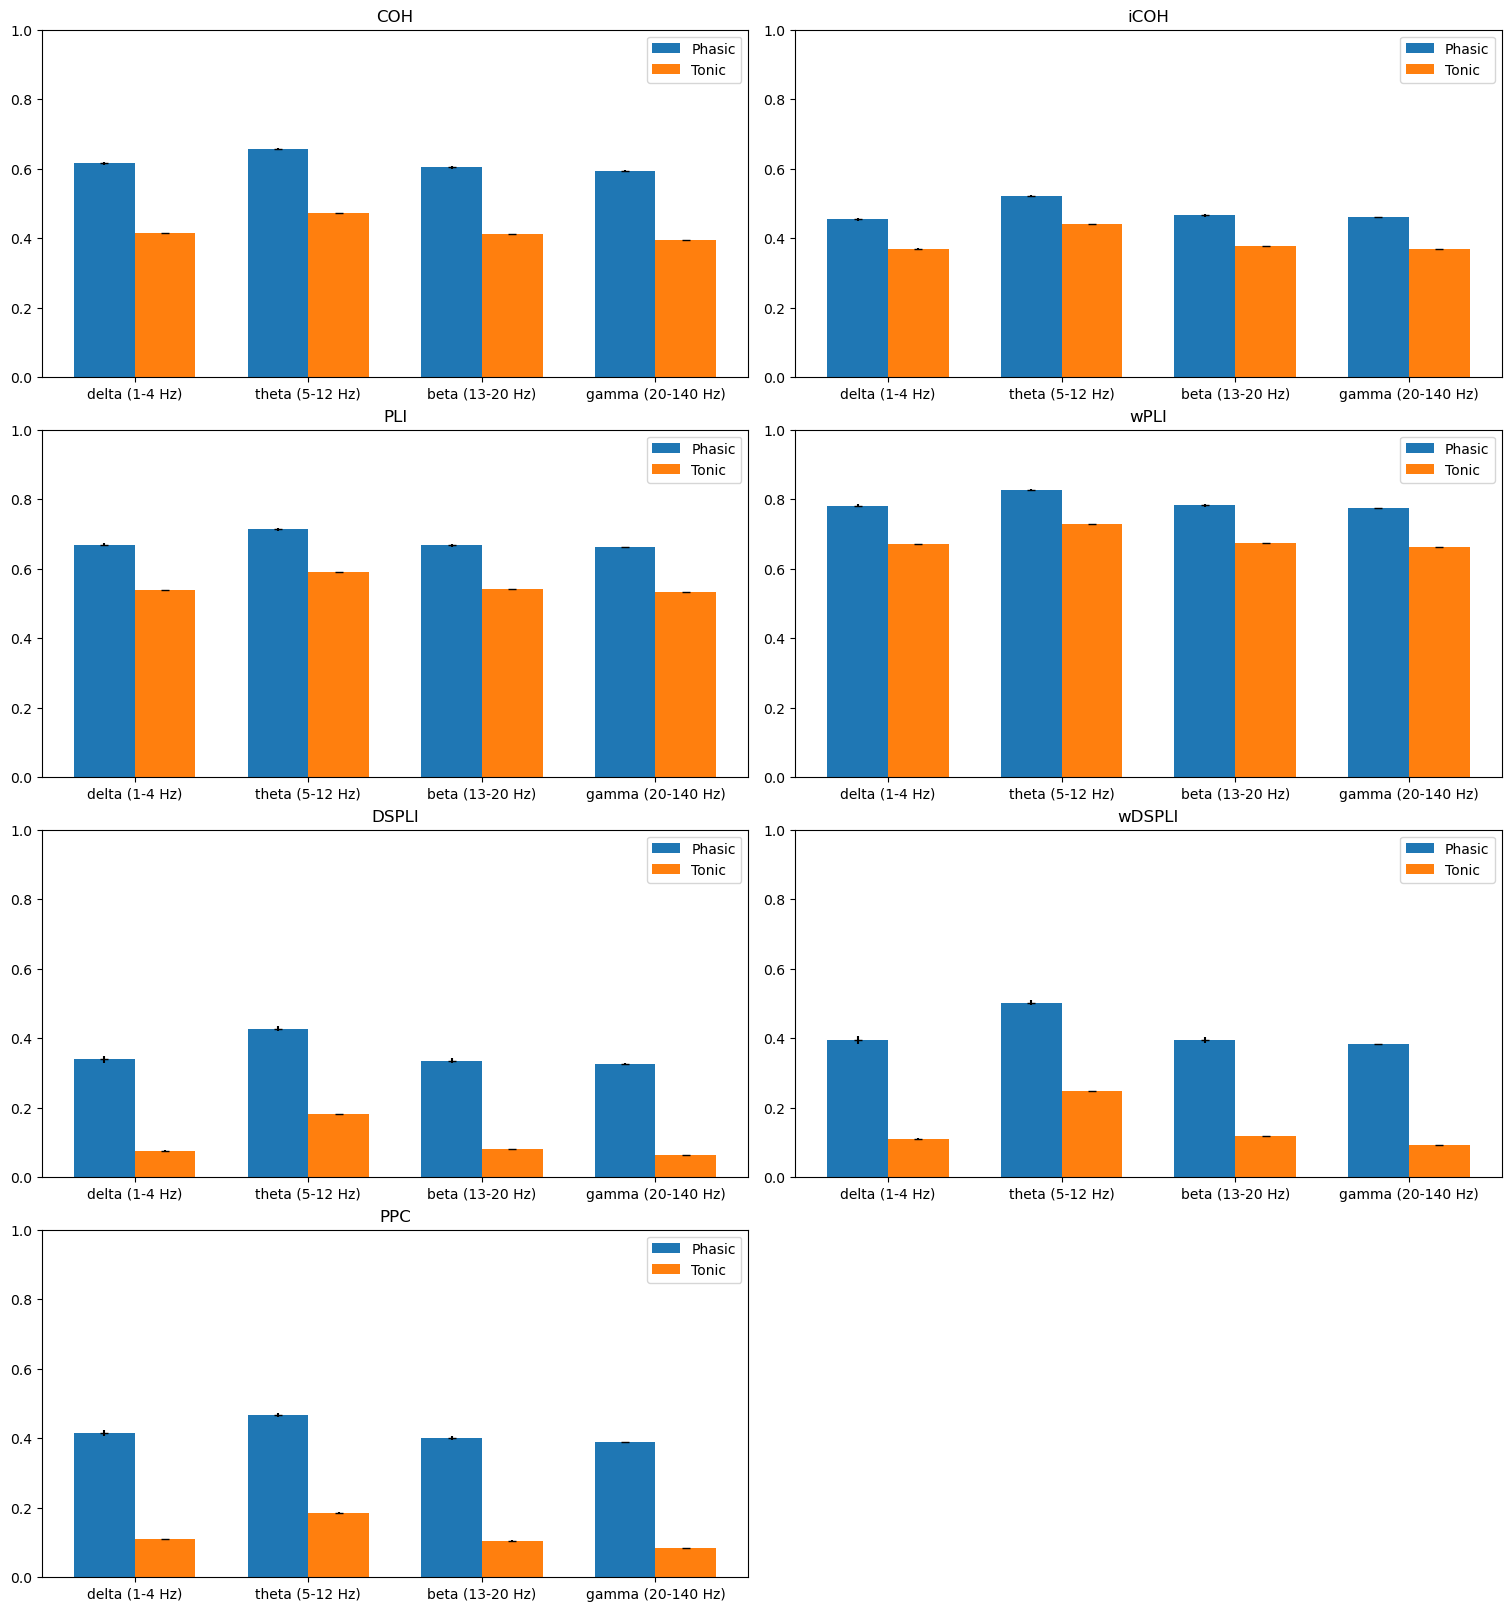

In [28]:
panel_grid = [
    ["COH",   "iCOH"],
    ["PLI",   "wPLI"],
    ["DSPLI", "wDSPLI"],
    ["PPC",   None]
]

df = df_all

fig, axes = plt.subplots(
    nrows=4, ncols=2, figsize=(15, 16), constrained_layout=True
)

for row in range(4):
    for col in range(2):

        measure = panel_grid[row][col]
        ax = axes[row, col]

        if measure is None:
            ax.axis("off")
            continue

        mean_p, sem_p, mean_t, sem_t = get_arrays(measure)

        # --- phasic CI ---
        ci_lo_p, ci_hi_p = mean_ci(mean_p, sem_p)
        yerr_p = np.vstack([mean_p - ci_lo_p, ci_hi_p - mean_p])

        ax.bar(x + offsets["phasic"], mean_p, width=w, label="Phasic")
        ax.errorbar(x + offsets["phasic"], mean_p, yerr=yerr_p,
                    fmt="_", color="black")

        # --- tonic CI ---
        ci_lo_t, ci_hi_t = mean_ci(mean_t, sem_t)
        yerr_t = np.vstack([mean_t - ci_lo_t, ci_hi_t - mean_t])

        ax.bar(x + offsets["tonic"], mean_t, width=w, label="Tonic")
        ax.errorbar(x + offsets["tonic"], mean_t, yerr=yerr_t,
                    fmt="_", color="black")

        ax.set_title(measure)
        ax.set_xticks(x)
        ax.set_xticklabels(cats)
        ax.set_ylim(0, 1)
        ax.legend()

plt.savefig('connectivity_ALL.jpeg')
plt.show()

In [29]:
bands = ["delta", "theta", "beta", "gamma"]
measures = ["coh", "icoh", "pli", "wpli", "dspli", "wdspli", "ppc"]

def mean_ci(mean, sem, alpha=0.05):
    z = 1.96  # 95% CI
    lower = mean - z * sem
    upper = mean + z * sem
    return lower, upper

def compute_ci_table(suffix):
    ci_rows = []
    for i, band in enumerate(bands):
        for m in measures:
            mean_p = globals()[f"mean_{m}_phasic_{suffix}"][i]
            sem_p  = globals()[f"sem_{m}_phasic_{suffix}"][i]

            mean_t = globals()[f"mean_{m}_tonic_{suffix}"][i]
            sem_t  = globals()[f"sem_{m}_tonic_{suffix}"][i]

            p_lo, p_hi = mean_ci(mean_p, sem_p)
            t_lo, t_hi = mean_ci(mean_t, sem_t)

            significant = not (p_hi >= t_lo and t_hi >= p_lo)

            ci_rows.append({
                "measure": m,
                "band": band,
                "phasic_mean": mean_p,
                "tonic_mean": mean_t,
                "phasic_ci": (p_lo, p_hi),
                "tonic_ci": (t_lo, t_hi),
                "significant": significant
            })

    return pd.DataFrame(ci_rows)

df_ci_all   = compute_ci_table("all")
df_ci_learn = compute_ci_table("learn")
df_ci_CN    = compute_ci_table("CN")
df_ci_OD    = compute_ci_table("OD")
df_ci_OR    = compute_ci_table("OR")
df_ci_HC    = compute_ci_table("HC")

In [30]:
def ci_star(mean_p, sem_p, mean_t, sem_t):
    z = 1.96  # 95% CI
    p_lo, p_hi = mean_p - z * sem_p, mean_p + z * sem_p
    t_lo, t_hi = mean_t - z * sem_t, mean_t + z * sem_t

    # non-overlapping CIs → significant
    return "*" if not (p_hi >= t_lo and t_hi >= p_lo) else "ns"

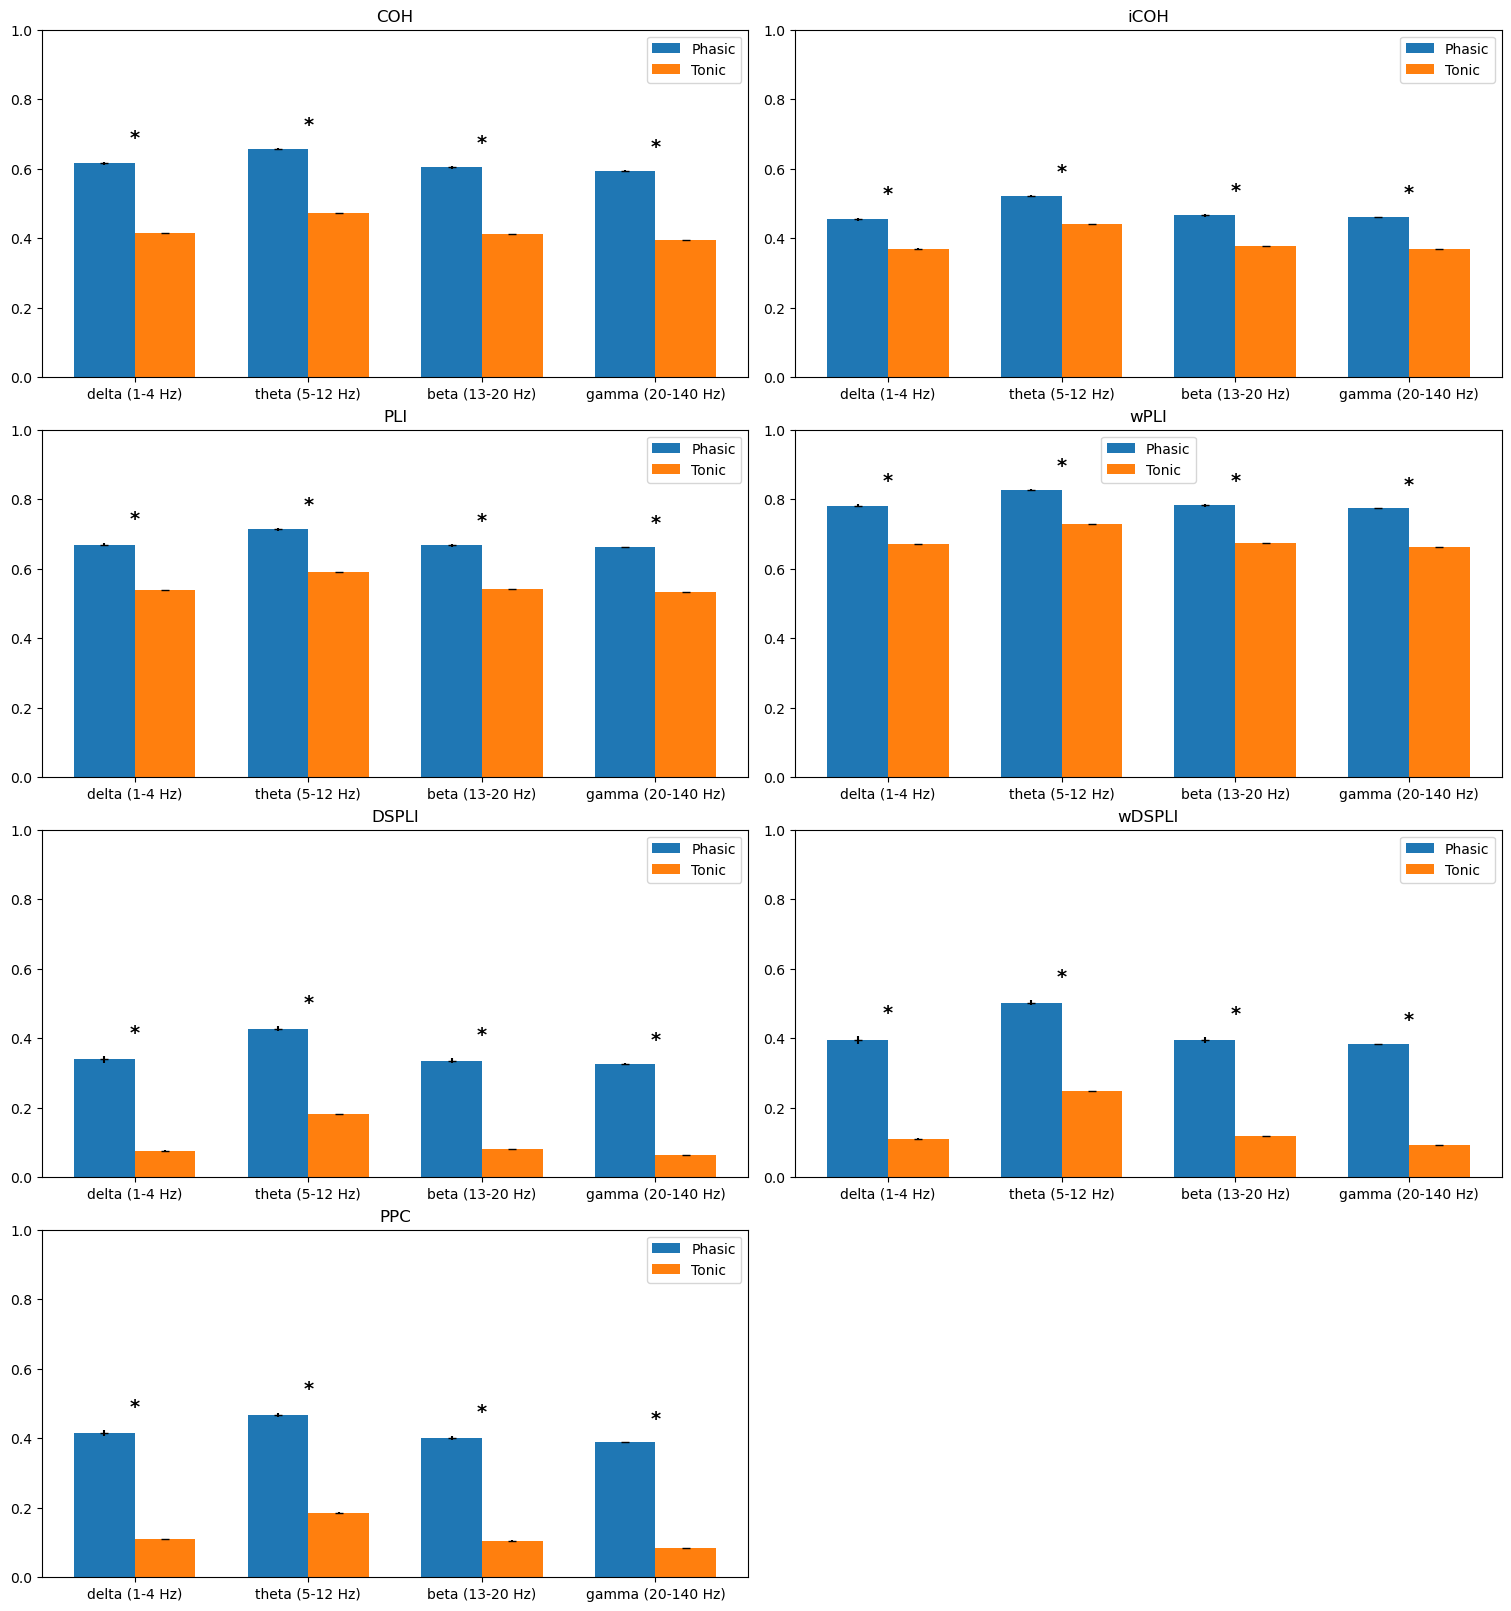

In [31]:
panel_grid = [
    ["COH",   "iCOH"],
    ["PLI",   "wPLI"],
    ["DSPLI", "wDSPLI"],
    ["PPC",   None]
]

fig, axes = plt.subplots(
    nrows=4, ncols=2, figsize=(15, 16), constrained_layout=True
)

for row in range(4):
    for col in range(2):

        measure = panel_grid[row][col]
        ax = axes[row, col]

        if measure is None:
            ax.axis("off")
            continue

        mean_p, sem_p, mean_t, sem_t = get_arrays(measure)

        # --- phasic CI error bars ---
        ci_lo_p = mean_p - 1.96 * sem_p
        ci_hi_p = mean_p + 1.96 * sem_p
        yerr_p = np.vstack([mean_p - ci_lo_p, ci_hi_p - mean_p])

        ax.bar(x + offsets["phasic"], mean_p, width=w, label="Phasic")
        ax.errorbar(x + offsets["phasic"], mean_p, yerr=yerr_p,
                    fmt="_", color="black")

        # --- tonic CI error bars ---
        ci_lo_t = mean_t - 1.96 * sem_t
        ci_hi_t = mean_t + 1.96 * sem_t
        yerr_t = np.vstack([mean_t - ci_lo_t, ci_hi_t - mean_t])

        ax.bar(x + offsets["tonic"], mean_t, width=w, label="Tonic")
        ax.errorbar(x + offsets["tonic"], mean_t, yerr=yerr_t,
                    fmt="_", color="black")

        # stars per frequency band
        for i_band in range(len(x)):
            star = ci_star(
                mean_p[i_band], sem_p[i_band],
                mean_t[i_band], sem_t[i_band]
            )

            if star == "ns":
                continue

            # NOTE: Use CI upper bound to position star correctly
            y_max = max(
                mean_p[i_band] + 1.96 * sem_p[i_band],
                mean_t[i_band] + 1.96 * sem_t[i_band]
            )

            ax.text(
                x[i_band],
                y_max + 0.04,
                star,
                ha="center",
                va="bottom",
                fontsize=14,
                fontweight="bold"
            )

        ax.set_title(measure)
        ax.set_xticks(x)
        ax.set_xticklabels(cats)
        ax.set_ylim(0, 1)
        ax.legend()

plt.savefig('connectivity_ALLstar.jpeg')
plt.show()


# Learning vs HC

In [32]:
def ci_overlap_star(mean1, sem1, mean2, sem2):
    z = 1.96
    lo1, hi1 = mean1 - z*sem1, mean1 + z*sem1
    lo2, hi2 = mean2 - z*sem2, mean2 + z*sem2

    return "*" if not (hi1 >= lo2 and hi2 >= lo1) else "ns"

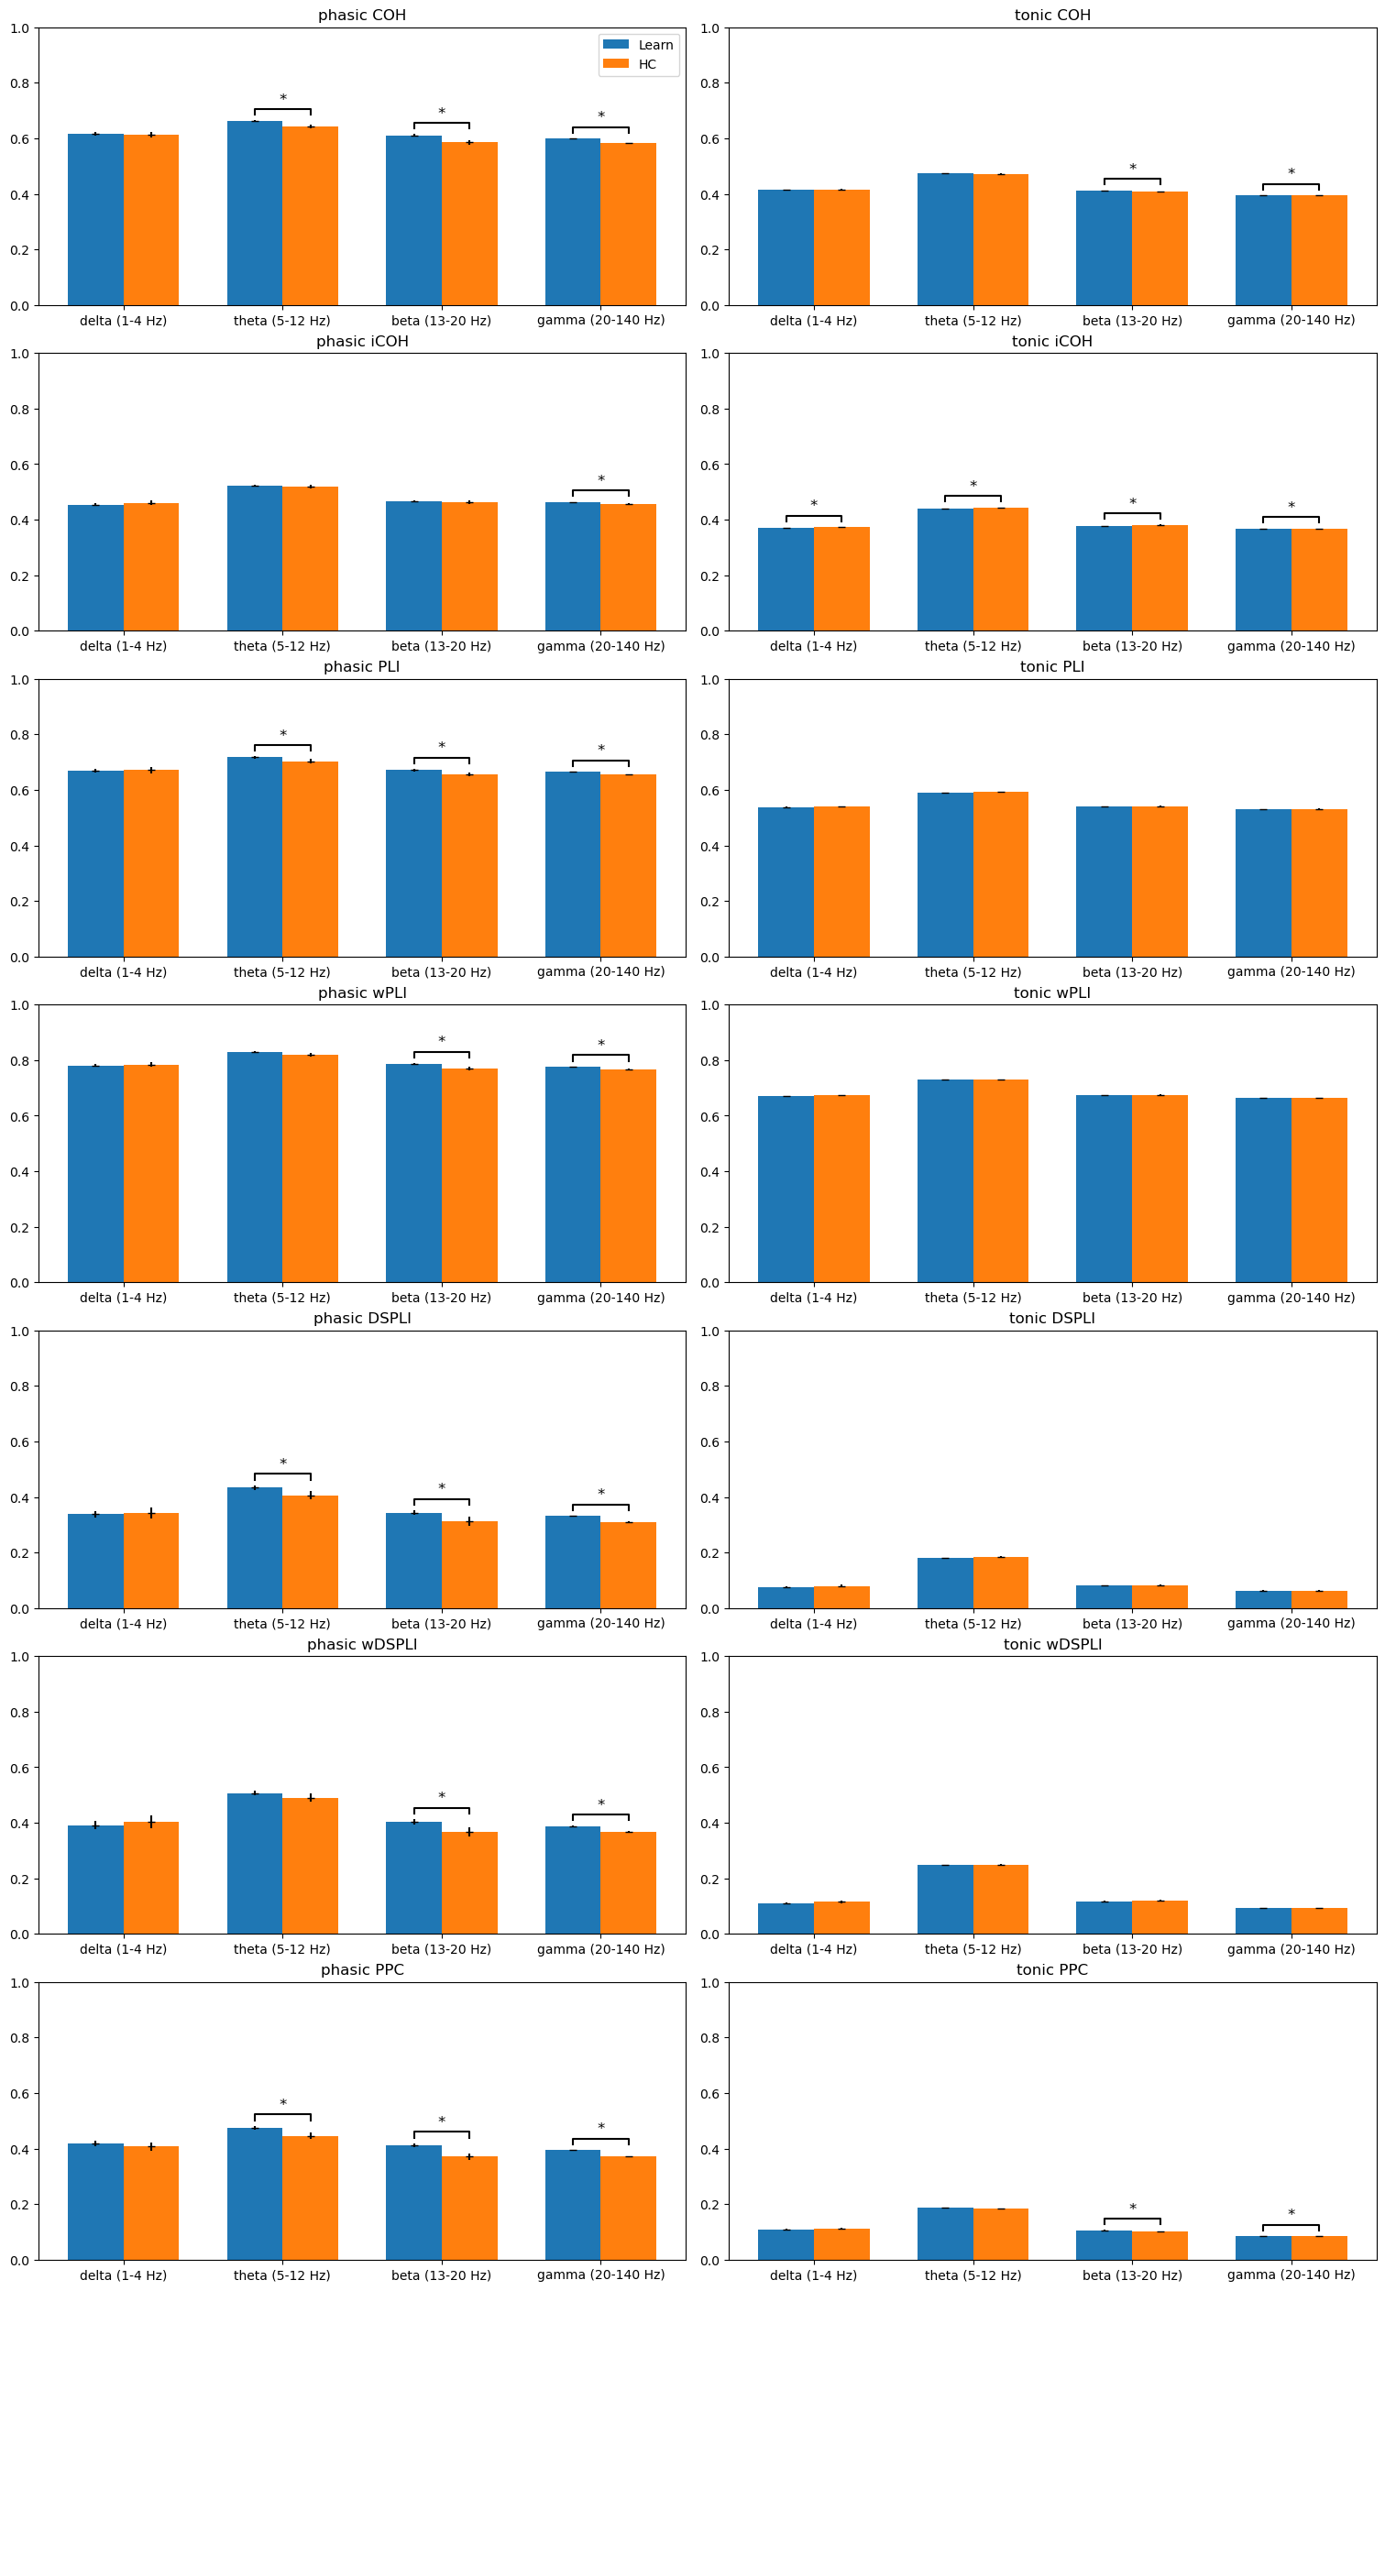

In [36]:
def get_arrays_learn_vs_HC(measure):
    mean_lp = df_learn.loc["phasic delta":"phasic gamma", measure].values
    sem_lp  = df_learn.loc["phasic delta":"phasic gamma", f"SE {measure}"].values

    mean_hp = df_HC.loc["phasic delta":"phasic gamma", measure].values
    sem_hp  = df_HC.loc["phasic delta":"phasic gamma", f"SE {measure}"].values

    mean_lt = df_learn.loc["tonic delta":"tonic gamma", measure].values
    sem_lt  = df_learn.loc["tonic delta":"tonic gamma", f"SE {measure}"].values

    mean_ht = df_HC.loc["tonic delta":"tonic gamma", measure].values
    sem_ht  = df_HC.loc["tonic delta":"tonic gamma", f"SE {measure}"].values

    return mean_lp, sem_lp, mean_hp, sem_hp, mean_lt, sem_lt, mean_ht, sem_ht

def add_bracket(ax, x1, x2, y, text):
    """
    Draws a bracket between x1 and x2 at height y and writes text above it.
    """
    ax.plot([x1, x1, x2, x2], [y, y+0.02, y+0.02, y], lw=1.5, color="black")
    ax.text((x1 + x2) / 2, y + 0.03, text, ha="center", va="bottom", fontsize=12)


panel_grid = [
    ["COH",   "COH"],
    ["iCOH",  "iCOH"],
    ["PLI",   "PLI"],
    ["wPLI",  "wPLI"],
    ["DSPLI", "DSPLI"],
    ["wDSPLI","wDSPLI"],
    ["PPC",   "PPC"],
    [None,    None]
]

w = 0.35
x = np.arange(len(cats))
offsets = {"learn": -w/2, "HC": w/2}

fig, axes = plt.subplots(
    nrows=8, ncols=2, figsize=(15, 28), constrained_layout=True
)

for row in range(8):
    for col in range(2):

        measure = panel_grid[row][col]
        ax = axes[row, col]

        if measure is None:
            ax.axis("off")
            continue

        (mean_lp, sem_lp, mean_hp, sem_hp,
         mean_lt, sem_lt, mean_ht, sem_ht) = get_arrays_learn_vs_HC(measure)

        if col == 0:  # phasic
            mean_p, sem_p = mean_lp, sem_lp
            mean_h, sem_h = mean_hp, sem_hp
            title_suffix = "phasic"
        else:         # tonic
            mean_p, sem_p = mean_lt, sem_lt
            mean_h, sem_h = mean_ht, sem_ht
            title_suffix = "tonic"

        # --- CI error bars ---
        yerr_p = np.vstack([1.96 * sem_p, 1.96 * sem_p])
        yerr_h = np.vstack([1.96 * sem_h, 1.96 * sem_h])

        # bars
        ax.bar(x + offsets["learn"], mean_p, width=w, label="Learn")
        ax.errorbar(x + offsets["learn"], mean_p, yerr=yerr_p,
                    fmt="_", color="black")

        ax.bar(x + offsets["HC"], mean_h, width=w, label="HC")
        ax.errorbar(x + offsets["HC"], mean_h, yerr=yerr_h,
                    fmt="_", color="black")

        # significance bracket
        for i_band in range(len(x)):
            star = ci_star(mean_p[i_band], sem_p[i_band],
                           mean_h[i_band], sem_h[i_band])

            if star == "ns":
                continue

            # use CI upper bound for bracket height
            y_max = max(mean_p[i_band] + 1.96 * sem_p[i_band],
                        mean_h[i_band] + 1.96 * sem_h[i_band])

            add_bracket(ax, x[i_band] + offsets["learn"],
                        x[i_band] + offsets["HC"],
                        y_max + 0.02, star)

        ax.set_title(f"{title_suffix} {measure}")
        ax.set_xticks(x)
        ax.set_xticklabels(cats)
        ax.set_ylim(0, 1)

        if row == 0 and col == 0:
            ax.legend()

plt.savefig('connectivity_learnHC.jpeg')
plt.show()

# Conditions vs conditions

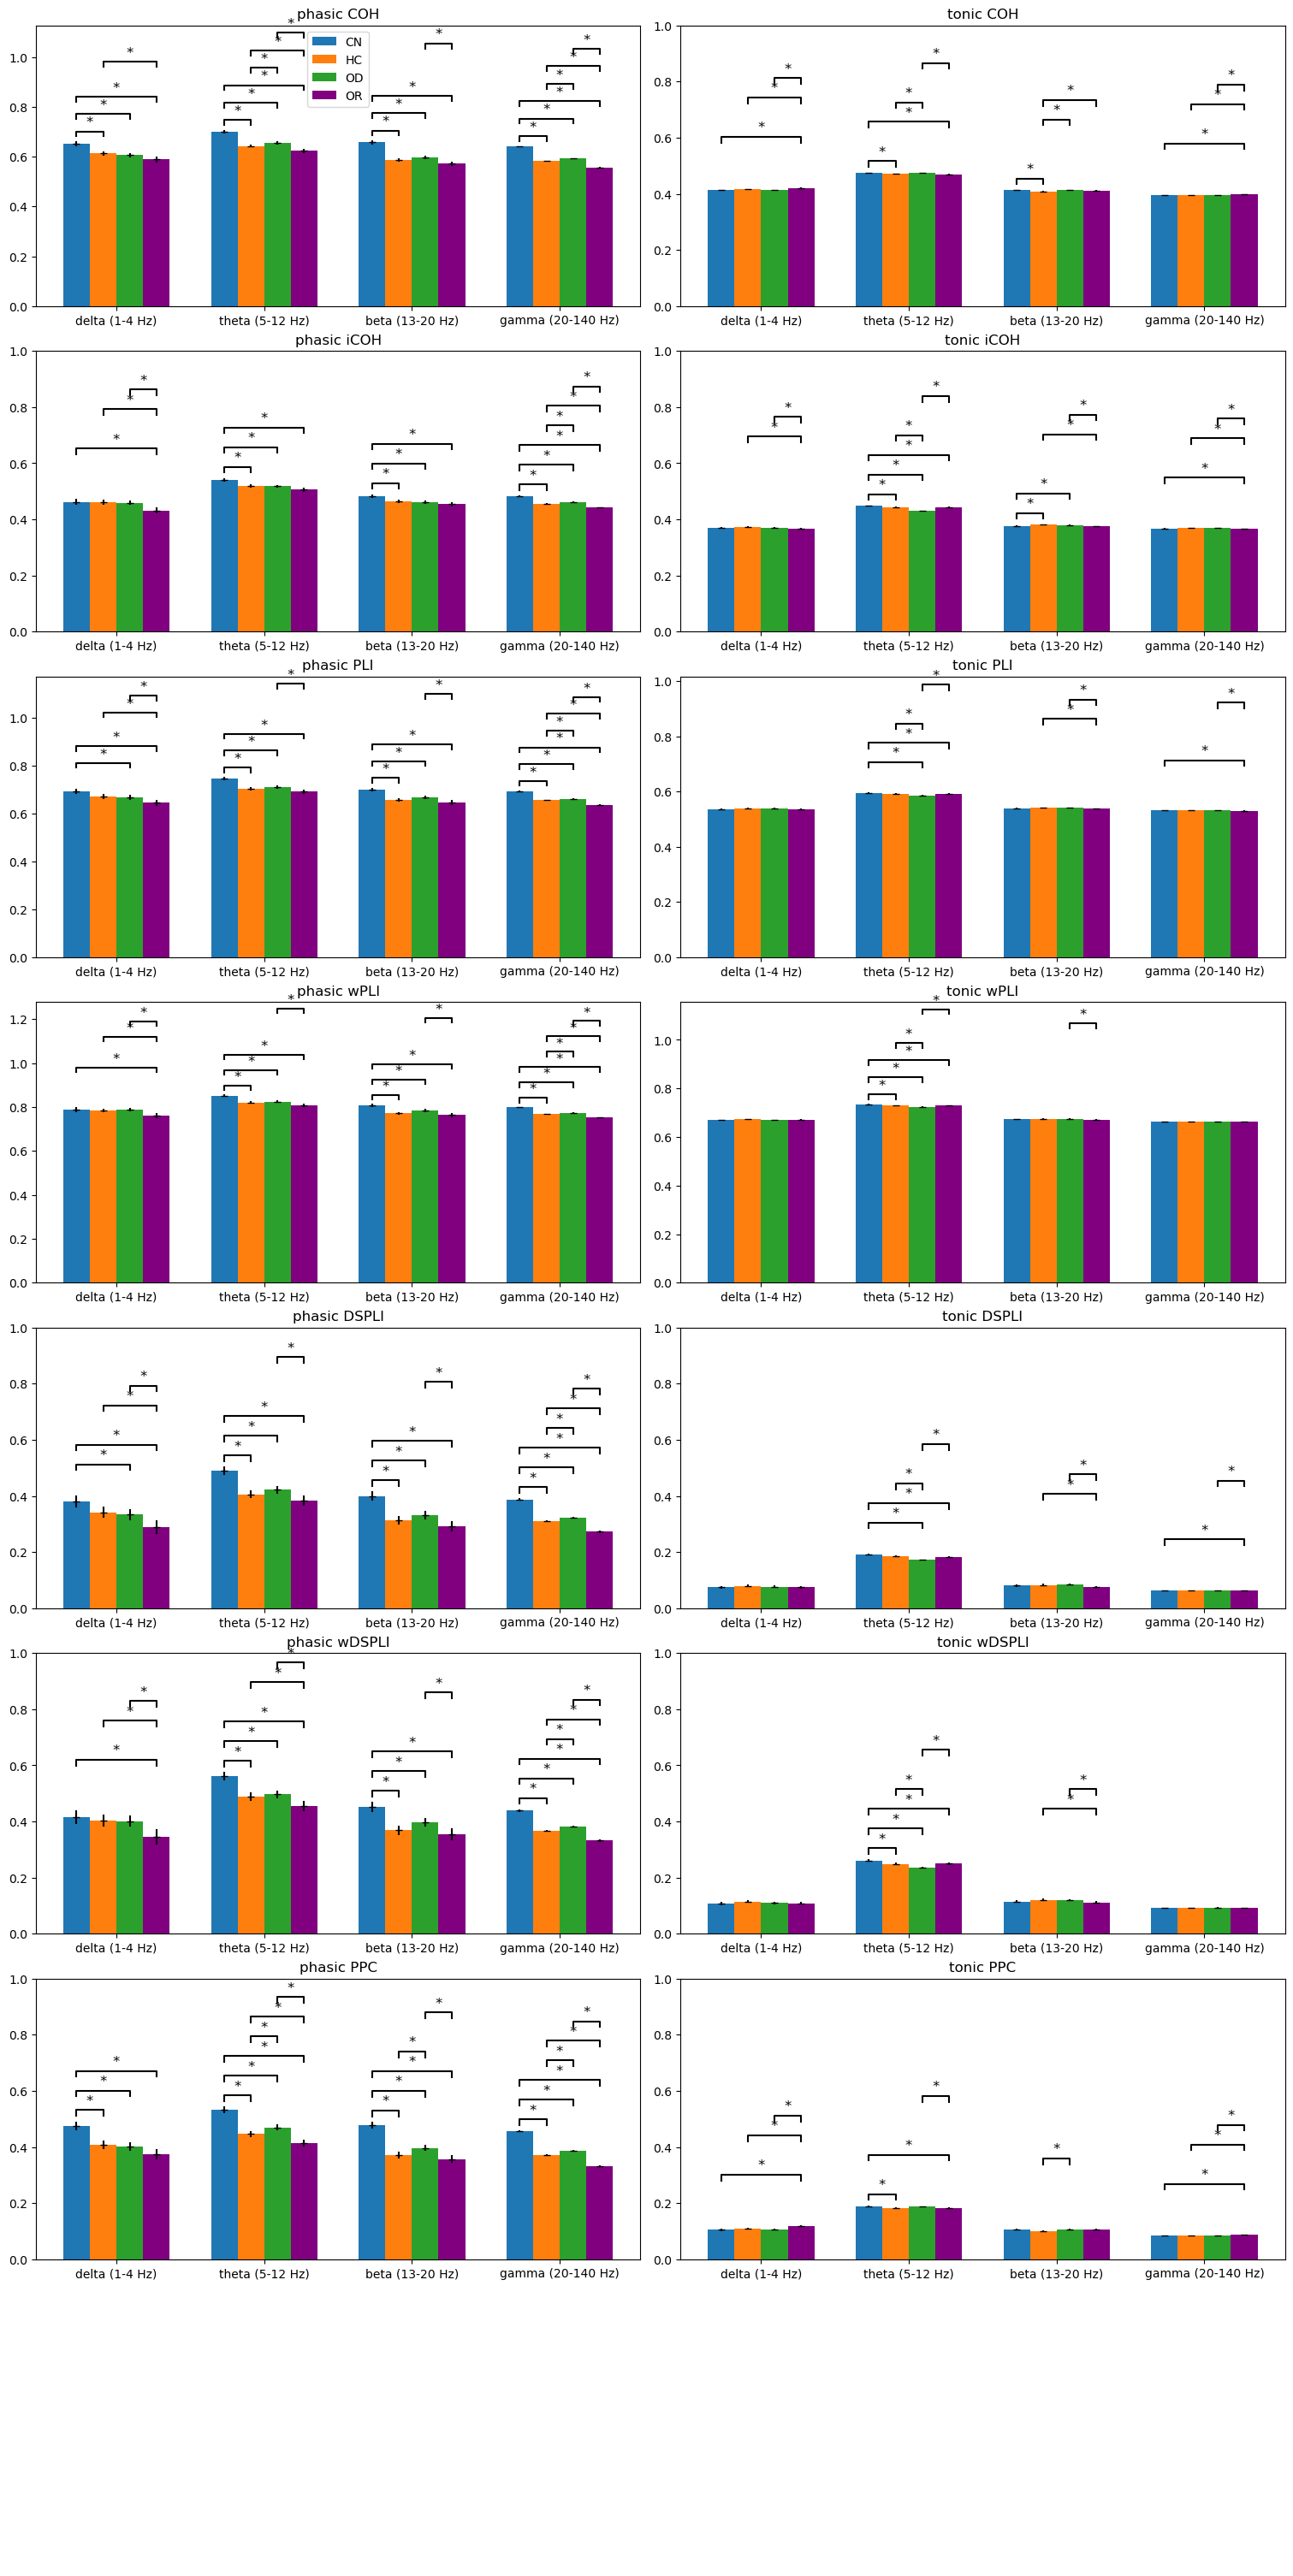

In [37]:
def ci_overlap_star(mean1, sem1, mean2, sem2):
    z = 1.96
    lo1, hi1 = mean1 - z*sem1, mean1 + z*sem1
    lo2, hi2 = mean2 - z*sem2, mean2 + z*sem2
    return "*" if not (hi1 >= lo2 and hi2 >= lo1) else "ns"


def get_arrays_4conditions(measure):
    phasic = {}
    tonic  = {}

    for cond in ["CN", "HC", "OD", "OR"]:
        phasic[cond] = df_dict[cond].loc["phasic delta":"phasic gamma", measure].values
        tonic[cond]  = df_dict[cond].loc["tonic delta":"tonic gamma", measure].values

    return phasic, tonic


def add_bracket(ax, x1, x2, y, text):
    """
    Draws a bracket between x1 and x2 at height y and writes text above it.
    """
    ax.plot([x1, x1, x2, x2], [y, y+0.02, y+0.02, y], lw=1.5, color="black")
    ax.text((x1 + x2) / 2, y + 0.03, text, ha="center", va="bottom", fontsize=12)


panel_grid = [
    ["COH",   "COH"],
    ["iCOH",  "iCOH"],
    ["PLI",   "PLI"],
    ["wPLI",  "wPLI"],
    ["DSPLI", "DSPLI"],
    ["wDSPLI","wDSPLI"],
    ["PPC",   "PPC"],
    [None,    None]
]

w = 0.18
x = np.arange(len(cats))

offsets = {
    "CN": -1.5*w,
    "HC": -0.5*w,
    "OD":  0.5*w,
    "OR":  1.5*w
}

pairs = [
    ("CN", "HC"),
    ("CN", "OD"),
    ("CN", "OR"),
    ("HC", "OD"),
    ("HC", "OR"),
    ("OD", "OR")
]

df_dict = {
    "CN": df_CN,
    "HC": df_HC,
    "OD": df_OD,
    "OR": df_OR
}

fig, axes = plt.subplots(
    nrows=8, ncols=2, figsize=(15, 30), constrained_layout=True
)

for row in range(8):
    for col in range(2):

        measure = panel_grid[row][col]
        ax = axes[row, col]

        if measure is None:
            ax.axis("off")
            continue

        phasic, tonic = get_arrays_4conditions(measure)

        if col == 0:
            data = phasic
            title_suffix = "phasic"
        else:
            data = tonic
            title_suffix = "tonic"

        max_bracket_y = 0  # <-- track highest bracket
        colors = {"CN": None, "HC": None, "OD": None, "OR": "purple"}

        # plot 4 bars + CI error bars
        for cond in ["CN", "HC", "OD", "OR"]:
            sem = df_dict[cond].loc[f"{title_suffix} delta":f"{title_suffix} gamma", f"SE {measure}"].values
            yerr = np.vstack([1.96 * sem, 1.96 * sem])

            ax.bar(x + offsets[cond], data[cond], width=w, label=cond, color=colors[cond])
            ax.errorbar(x + offsets[cond], data[cond], yerr=yerr, fmt="_", color="black")

        # add brackets and stars
        for i_band in range(len(x)):
            m = {cond: data[cond][i_band] for cond in data}
            s = {
                cond: df_dict[cond].loc[f"{title_suffix} delta":f"{title_suffix} gamma", f"SE {measure}"].values[i_band]
                for cond in data
            }

            y_base = max([m[c] + 1.96*s[c] for c in m]) + 0.02

            for j, (c1, c2) in enumerate(pairs):
                star = ci_overlap_star(m[c1], s[c1], m[c2], s[c2])
                if star == "ns":
                    continue

                y = y_base + j*0.07
                max_bracket_y = max(max_bracket_y, y + 0.05)  # keep track

                x1 = x[i_band] + offsets[c1]
                x2 = x[i_band] + offsets[c2]

                add_bracket(ax, x1, x2, y, star)

        # ---- Fix overflow by extending ylimit ----
        ax.set_ylim(0, max(1, max_bracket_y))

        ax.set_title(f"{title_suffix} {measure}")
        ax.set_xticks(x)
        ax.set_xticklabels(cats)

        if row == 0 and col == 0:
            ax.legend()


plt.savefig('connectivity_conditions.jpeg')
plt.savefig('connectivity_conditions.png')
plt.show()